Chemistry-Informed Polymer Electrolyte Prediction for Ionic Conductivity - Featurization

In this code, the goal is to find best features to predict ionic conductivity using only molecular features from RDkit, DelFTa, and physics-informed equations. The features of interests are chosen either through literature or chemical intuition, but must be available on RDkit. Once this is complete, correlation matrix and linear regression will first be used to predict for ionic conductivity and see if the features are feasible for the next step of applying it into Random Forest. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, rdmolops
import rdkit.Chem as Chem_mod
from rdkit.Chem import rdPartialCharges

In [2]:
_have_brics = False
_have_rdFreeSASA = False
_have_estate = False
try:
    from rdkit.Chem import BRICS
    _have_brics = True
except Exception:
    _have_brics = False

try:
    # rdFreeSASA calculates SASA given 3D coords and vdW radii
    from rdkit.Chem import rdFreeSASA
    from rdkit.Chem.rdFreeSASA import Classifier as SASA_Classifier  # just to detect presence
    _have_rdFreeSASA = True
except Exception:
    _have_rdFreeSASA = False

try:
    from rdkit.Chem import EState
    _have_estate = True
except Exception:
    _have_estate = False

import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('simulation-trajectory-aggregate.csv')
df.head()

,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,0.317530
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,0.529740
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,0.080645


In [4]:
num_dupe = df.duplicated().sum() 
num_miss = df.isnull().values.any() 

print(f"Number of duplicate rows: {num_dupe}")
print(f"Number of missing values: {num_miss}")

Number of duplicate rows: 0
Number of missing values: False


In [5]:
df.columns

Index(['Trajectory ID', 'Mol smiles', 'Molality', 'Monomer Molecular Weight',
       'Degree of Polymerization', 'Density', 'CONDUCTIVITY',
       'TFSI Diffusivity', 'Li Diffusivity', 'Poly Diffusivity',
       'Transference Number'],
      dtype='object')

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6270 entries, 0 to 6269
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Trajectory ID             6270 non-null   int64  
 1   Mol smiles                6270 non-null   object 
 2   Molality                  6270 non-null   float64
 3   Monomer Molecular Weight  6270 non-null   float64
 4   Degree of Polymerization  6270 non-null   float64
 5   Density                   6270 non-null   float64
 6   CONDUCTIVITY              6270 non-null   float64
 7   TFSI Diffusivity          6270 non-null   float64
 8   Li Diffusivity            6270 non-null   float64
 9   Poly Diffusivity          6270 non-null   float64
 10  Transference Number       6270 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 539.0+ KB
None


In [7]:
# first, we remove the tracer particles, [Au] and [Cu], from the SMILES strings
df["Mol_smiles_clean"] = (
    df["Mol smiles"]
    .str.replace(r"\[Cu\]", "", regex=True)
    .str.replace(r"\[Au\]", "", regex=True)
    .str.replace(r"\(\)", "", regex=True)   # <-- fixes empty parentheses
    .str.strip()
)

# we then validate the SMILES strings by attempting to convert them to RDKit Mol objects
valid_list = []
mol_list = []
for smi in df["Mol_smiles_clean"]:
    try:
        mol = Chem.MolFromSmiles(smi)
        mol_list.append(mol)
        valid_list.append(mol is not None)
    except:
        mol_list.append(None)
        valid_list.append(False)

df["is_valid"] = valid_list
df["mol_obj"] = mol_list

df_valid = df[df["is_valid"]].copy()

print(f"Valid molecules: {df_valid.shape[0]} / {df.shape[0]}")
df.head()

Valid molecules: 6270 / 6270


,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number,Mol_smiles_clean,is_valid,mol_obj
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760,COCC(CNCC(CF)OC(=O))O,True,<rdkit.Chem.rdchem.Mol object at 0x1a83d7840>
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,0.317530,O=C(CCNC(=O)COC(=O))NCCN,True,<rdkit.Chem.rdchem.Mol object at 0x1a83d78b0>
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,0.529740,NC(=O)C(COC(=O))NC(=O)CCO,True,<rdkit.Chem.rdchem.Mol object at 0x1a83d7920>
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160,CC(COC(=O))COC(=O)C(C)(C)CO,True,<rdkit.Chem.rdchem.Mol object at 0x1a83d7990>
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,0.080645,COC(=O)CC(=O)NC(CO)COC(=O),True,<rdkit.Chem.rdchem.Mol object at 0x1a83d7a00>



=== Correlation with ionic conductivity ===
CONDUCTIVITY                1.000000
Li Diffusivity              0.775403
TFSI Diffusivity            0.769289
Poly Diffusivity            0.763121
Transference Number         0.200902
Molality                    0.071394
Density                    -0.036744
Monomer Molecular Weight   -0.041691
Trajectory ID              -0.101510
Degree of Polymerization   -0.140197
Name: CONDUCTIVITY, dtype: float64


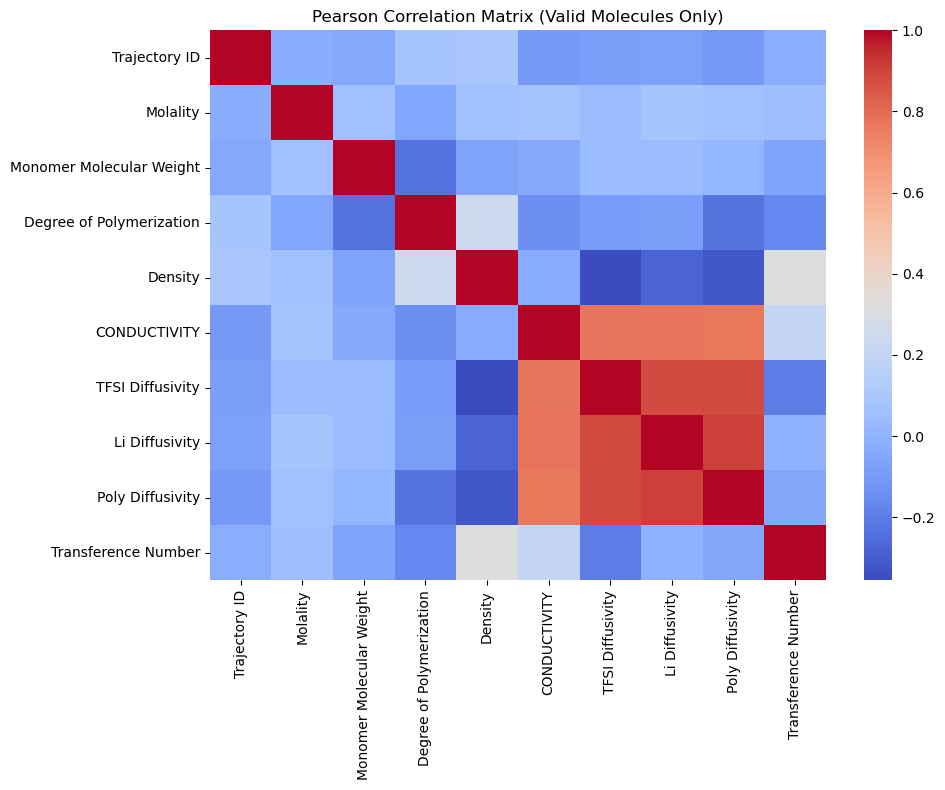

In [8]:
# let's see how the features correlate with ionic conductivity first

numeric_cols = df_valid.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Change this if your column name differs
target = "CONDUCTIVITY"

if target not in numeric_cols:
    raise ValueError(f"Column '{target}' not found among numeric columns.")

corr_matrix = df_valid[numeric_cols].corr(method="pearson")

# Show correlations with ionic conductivity
corr_target = corr_matrix[target].sort_values(ascending=False)
print("\n=== Correlation with ionic conductivity ===")
print(corr_target)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Pearson Correlation Matrix (Valid Molecules Only)")
plt.tight_layout()
plt.show()

In [ ]:
# add individual element and counts as features
all_elements = set()

for mol in df_valid["mol_obj"]:
    for atom in mol.GetAtoms():
        all_elements.add(atom.GetSymbol())

print("All detected elements:", all_elements)

def count_elements(mol, elements):
    counts = {}
    for e in elements:
        counts[f"Count_{e}"] = 0

    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol in elements:
            counts[f"Count_{symbol}"] += 1
    return counts

element_feature_rows = [
    count_elements(mol, all_elements)
    for mol in df_valid["mol_obj"]
]

df_elements = pd.DataFrame(element_feature_rows)

hetero_cols = [c for c in df_elements.columns if not c.endswith("_H") and not c.endswith("_C") and not c.endswith("_O") and not c.endswith("_N")]
# but we want heteroatoms = all atoms except C and H:
if ("Count_C" in df_elements.columns) and ("Count_H" in df_elements.columns):
    df_elements["Heteroatom_count"] = df_elements.sum(axis=1) - df_elements["Count_C"] - df_elements["Count_H"] - df_elements["Count_O"] - df_elements["Count_N"]
else:
    # fallback: sum counts except C, H, and O if present
    non_ch_cols = [c for c in df_elements.columns if c not in ("Count_C", "Count_H", "Count_O", "Count_N")]
    df_elements["Heteroatom_count"] = df_elements[non_ch_cols].sum(axis=1)
df_elements.head()

All detected elements: {'P', 'Cl', 'O', 'Si', 'C', 'F', 'N', 'S'}


,Count_P,Count_Cl,Count_O,Count_Si,Count_C,Count_F,Count_N,Count_S,Heteroatom_count
0,0,0,4,0,8,1,1,0,1
1,0,0,4,0,8,0,3,0,0
2,0,0,5,0,7,0,2,0,0
3,0,0,5,0,10,0,0,0,0
4,0,0,6,0,8,0,1,0,0


In [10]:
# brics fragments (block-level fragments)
brics_frag_counts = []
brics_frag_unique = []
if _have_brics:
    for mol in df_valid["mol_obj"]:
        try:
            smi = Chem.MolToSmiles(mol)
            frags = BRICS.BRICSDecompose(smi)  # set of fragment SMILES
            frags = set(frags)
            brics_frag_unique.append(len(frags))
            # store size of largest fragment (heavy atoms)
            max_size = 0
            for f in frags:
                fm = Chem.MolFromSmiles(f)
                if fm is None:
                    continue
                size = rdMolDescriptors.CalcNumHeavyAtoms(fm)
                if size > max_size:
                    max_size = size
            brics_frag_counts.append({"BRICS_unique_frag_count": len(frags), "BRICS_largest_frag_heavy_atoms": max_size})
        except Exception:
            brics_frag_counts.append({"BRICS_unique_frag_count": np.nan, "BRICS_largest_frag_heavy_atoms": np.nan})
    df_brics = pd.DataFrame(brics_frag_counts)
else:
    print("BRICS module not available in this RDKit build — skipping BRICS fragment features.")
    df_brics = pd.DataFrame({"BRICS_unique_frag_count": [np.nan]*len(df_valid),
                            "BRICS_largest_frag_heavy_atoms": [np.nan]*len(df_valid)})

In [11]:
# chain-level features: topological diameter and estimated longest chain length
chain_features = []
for mol in df_valid["mol_obj"]:
    try:
        # topological distance matrix (shortest bond counts)
        dm = rdmolops.GetDistanceMatrix(mol)
        # some builds return numpy array, some nested lists: convert to numpy
        dm = np.array(dm, dtype=float)
        diam = np.nan
        if dm.size > 0:
            diam = np.nanmax(dm)  # maximum shortest-path length (bonds)
        # convert to number of atoms in longest chain ~ diam + 1
        longest_chain_len = int(diam + 1) if not np.isnan(diam) else np.nan
        chain_features.append({"Topological_diameter_bonds": diam, "Longest_chain_atoms_est": longest_chain_len})
    except Exception:
        chain_features.append({"Topological_diameter_bonds": np.nan, "Longest_chain_atoms_est": np.nan})
df_chain = pd.DataFrame(chain_features)

In [12]:
# atomic-level fragment counts
# Define SMARTS for some useful fragments (extendable)
smarts_patterns = {
    "carbonyl": "[CX3]=O",
    "ester": "[$([CX3](=O)[OX2H0]),$([CX3](=O)O)]",  # approximate
    "amine_primary": "[NX3;H2]",
    "amine_secondary": "[NX3;H1]",
    "tertiary_amine": "[NX3;!H0]",
    "sulfonyl": "S(=O)(=O)",   # rough
    "thiol": "[SX2H]",
    "phosphate": "P(=O)(O)O",
    "ether": "C-O-C",
    "aromatic_ring": "a1aaaaa1"  # rough; we will also use ring count
}

compiled_smarts = {k: Chem.MolFromSmarts(v) for k, v in smarts_patterns.items()}

frag_rows = []
estate_rows = []
for mol in df_valid["mol_obj"]:
    try:
        # functional fragment counts
        frag_counts = {}
        for name, patt in compiled_smarts.items():
            if patt is None:
                frag_counts[f"FG_{name}"] = np.nan
            else:
                matches = mol.GetSubstructMatches(patt)
                frag_counts[f"FG_{name}"] = len(matches)
        # ring count
        frag_counts["RingCount"] = mol.GetRingInfo().NumRings()
        # number of rings, aromatic rings
        frag_counts["AromaticAtomCount"] = sum(1 for a in mol.GetAtoms() if a.GetIsAromatic())
    except Exception:
        frag_counts = {f"FG_{k}": np.nan for k in compiled_smarts.keys()}
        frag_counts.update({"RingCount": np.nan, "AromaticAtomCount": np.nan})
    frag_rows.append(frag_counts)

    # EState per-atom aggregation if available
    if _have_estate:
        try:
            estate_vals = EState.EStateIndices(mol)  # returns tuple/list of per-atom estate indices
            estate_vals = [float(x) for x in estate_vals]
            estate_rows.append({
                "EState_sum": np.nansum(estate_vals),
                "EState_mean": np.nanmean(estate_vals),
                "EState_max": np.nanmax(estate_vals),
                "EState_min": np.nanmin(estate_vals),
                "EState_std": np.nanstd(estate_vals)
            })
        except Exception:
            estate_rows.append({"EState_sum": np.nan, "EState_mean": np.nan,
                                "EState_max": np.nan, "EState_min": np.nan, "EState_std": np.nan})
    else:
        estate_rows.append({"EState_sum": np.nan, "EState_mean": np.nan,
                            "EState_max": np.nan, "EState_min": np.nan, "EState_std": np.nan})

df_frags = pd.DataFrame(frag_rows)
df_estate = pd.DataFrame(estate_rows)


In [13]:
# partial charge features
charge_rows = []
for mol in df_valid["mol_obj"]:
    try:
        # Need to work on an editable copy for charges
        m2 = Chem.Mol(mol)
        # compute Gasteiger charges
        try:
            AllChem.ComputeGasteigerCharges(m2, throwOnFailure=False)
            g_charges = []
            for atom in m2.GetAtoms():
                ch = atom.GetProp("_GasteigerCharge") if atom.HasProp("_GasteigerCharge") else None
                if ch is None:
                    g_charges.append(np.nan)
                else:
                    try:
                        g_charges.append(float(ch))
                    except:
                        g_charges.append(np.nan)
        except Exception:
            # if Gasteiger failed, fill nans
            g_charges = [np.nan] * m2.GetNumAtoms()

        # aggregate
        g_max = np.nanmax(g_charges) if len(g_charges) > 0 else np.nan
        g_min = np.nanmin(g_charges) if len(g_charges) > 0 else np.nan
        g_mean = np.nanmean(g_charges) if len(g_charges) > 0 else np.nan
        g_std = np.nanstd(g_charges) if len(g_charges) > 0 else np.nan

        # formal charges
        total_formal = sum(atom.GetFormalCharge() for atom in m2.GetAtoms())
        num_pos_atoms = sum(1 for atom in m2.GetAtoms() if atom.GetFormalCharge() > 0)
        num_neg_atoms = sum(1 for atom in m2.GetAtoms() if atom.GetFormalCharge() < 0)
        charge_rows.append({
            "Gasteiger_max": g_max,
            "Gasteiger_min": g_min,
            "Gasteiger_mean": g_mean,
            "Gasteiger_std": g_std,
            "Total_formal_charge": total_formal,
            "Num_positive_atoms": num_pos_atoms,
            "Num_negative_atoms": num_neg_atoms
        })
    except Exception:
        charge_rows.append({
            "Gasteiger_max": np.nan, "Gasteiger_min": np.nan, "Gasteiger_mean": np.nan, "Gasteiger_std": np.nan,
            "Total_formal_charge": np.nan, "Num_positive_atoms": np.nan, "Num_negative_atoms": np.nan
        })

df_charges = pd.DataFrame(charge_rows)


In [14]:
#vdW/ SASA features
sasa_rows = []
if _have_rdFreeSASA:
    print("rdFreeSASA detected. Computing approximate SASA (requires 3D embedding; this may be slower).")
    for mol in df_valid["mol_obj"]:
        try:
            m3 = Chem.AddHs(Chem.Mol(mol))
            # embed 3D
            rc = AllChem.EmbedMolecule(m3, randomSeed=42)
            if rc != 0:
                # fallback: try again with ETKDG
                AllChem.EmbedMolecule(m3, randomSeed=42, params=AllChem.ETKDG())
            # optimize
            try:
                AllChem.UFFOptimizeMolecule(m3)
            except Exception:
                try:
                    AllChem.MMFFOptimizeMolecule(m3)
                except Exception:
                    pass
            # radii: use default vdW radii
            radii = rdFreeSASA.ClassicRadiusDict  # mapping from atomic number to vdw radius (if available)
            sasa = rdFreeSASA.CalcSASA(m3, rdFreeSASA.ClassicRadii)  # returns per-atom SASA array
            per_atom_sasa = np.array(sasa)
            sasa_rows.append({
                "SASA_sum": float(np.nansum(per_atom_sasa)),
                "SASA_mean": float(np.nanmean(per_atom_sasa)),
                "SASA_max": float(np.nanmax(per_atom_sasa)),
                "SASA_min": float(np.nanmin(per_atom_sasa))
            })
        except Exception:
            # fallback
            sasa_rows.append({"SASA_sum": np.nan, "SASA_mean": np.nan, "SASA_max": np.nan, "SASA_min": np.nan})
else:
    print("rdFreeSASA not available — using LabuteASA as an approximate surface area.")
    for mol in df_valid["mol_obj"]:
        try:
            lab = rdMolDescriptors.CalcLabuteASA(mol)
            sasa_rows.append({"SASA_sum": lab, "SASA_mean": np.nan, "SASA_max": np.nan, "SASA_min": np.nan})
        except Exception:
            sasa_rows.append({"SASA_sum": np.nan, "SASA_mean": np.nan, "SASA_max": np.nan, "SASA_min": np.nan})
df_sasa = pd.DataFrame(sasa_rows)


rdFreeSASA not available — using LabuteASA as an approximate surface area.


In [15]:
desc_rows = []
for mol in df_valid["mol_obj"]:
    try:
        # compute Gasteiger charges
        rdPartialCharges.ComputeGasteigerCharges(mol)
        charges = [float(atom.GetProp("_GasteigerCharge")) for atom in mol.GetAtoms()]

        row = {

            "MolWt": Descriptors.MolWt(mol),
            "MolLogP": Descriptors.MolLogP(mol),
            "LogP": Descriptors.MolLogP(mol),
            "TPSA": rdMolDescriptors.CalcTPSA(mol),
            "TPSA_ratio": rdMolDescriptors.CalcTPSA(mol)/Descriptors.MolWt(mol) if Descriptors.MolWt(mol)>0 else np.nan,
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            "HeavyAtomCount": Descriptors.HeavyAtomCount(mol),
            "LabuteASA": rdMolDescriptors.CalcLabuteASA(mol),
            "Chi0": Descriptors.Chi0(mol) if hasattr(Descriptors, "Chi0") else np.nan,
            "Chi1": Descriptors.Chi1(mol) if hasattr(Descriptors, "Chi1") else np.nan,
            "Chi2": Descriptors.Chi2(mol) if hasattr(Descriptors, "Chi2") else np.nan,
            "Kappa1": Descriptors.Kappa1(mol) if hasattr(Descriptors, "Kappa1") else np.nan,
            "Kappa2": Descriptors.Kappa2(mol) if hasattr(Descriptors, "Kappa2") else np.nan,
            "FractionCSP3": Descriptors.FractionCSP3(mol) if hasattr(Descriptors, "FractionCSP3") else np.nan,
            "RingCount": Descriptors.RingCount(mol),
            "NumAromaticRings": Descriptors.NumAromaticRings(mol),
            "NumAliphaticRings": Descriptors.NumAliphaticRings(mol),
            "MolCharge": Descriptors.TotalFormalCharge(mol) if hasattr(Descriptors, "TotalFormalCharge") else np.sum([a.GetFormalCharge() for a in mol.GetAtoms()]),
            "MaxCharge": max(charges),
            "MinCharge": min(charges),
            "MeanCharge": np.mean(charges),
        }
    except Exception:
        # fallback in case of error
        row = {k: np.nan for k in [
            "MolWt","MolLogP","LogP","TPSA","TPSA_ratio","NumHDonors","NumHAcceptors",
            "NumRotatableBonds","HeavyAtomCount","LabuteASA","Chi0","Chi1","Chi2","Kappa1","Kappa2",
            "FractionCSP3","RingCount","NumAromaticRings","NumAliphaticRings","MolCharge",
            "MaxCharge","MinCharge","MeanCharge","N","O","S","F","Cl"
        ]}
    desc_rows.append(row)

df_desc = pd.DataFrame(desc_rows)


In [26]:
df_final = pd.concat([
    df_valid.reset_index(drop=True),
    df_elements.reset_index(drop=True),
    df_brics.reset_index(drop=True),
    df_chain.reset_index(drop=True),
    df_desc.reset_index(drop=True),
    df_frags.reset_index(drop=True),
    df_estate.reset_index(drop=True),
    df_charges.reset_index(drop=True),
    df_sasa.reset_index(drop=True)
], axis=1)

df_final = df_final.loc[:, ~df_final.columns.duplicated()]
df_final

,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,...,Gasteiger_min,Gasteiger_mean,Gasteiger_std,Total_formal_charge,Num_positive_atoms,Num_negative_atoms,SASA_sum,SASA_mean,SASA_max,SASA_min
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,...,NaN,NaN,NaN,0,0,0,82.192090,NaN,NaN,NaN
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,...,NaN,NaN,NaN,0,0,0,87.331572,NaN,NaN,NaN
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,...,NaN,NaN,NaN,0,0,0,80.211002,NaN,NaN,NaN
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,...,NaN,NaN,NaN,0,0,0,89.368098,NaN,NaN,NaN
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,...,NaN,NaN,NaN,0,0,0,86.349599,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,29789,C=CC(O[Cu])C(=O)OCCC(C)(C)OC(=O)[Au],1.3617,474.73,17.0,1.2898,0.000037,2.621800e-08,1.083600e-08,1.632100e-08,...,NaN,NaN,NaN,0,0,0,88.678495,NaN,NaN,NaN
6266,29790,C=CC(CO[Cu])NCC(CCC)OC(=O)[Au],1.4559,459.76,19.0,1.2026,0.000037,2.438100e-08,2.447000e-08,2.782100e-08,...,NaN,NaN,NaN,0,0,0,84.953290,NaN,NaN,NaN
6267,29791,C#CCCN(CC(C)OC(=O)[Au])C(C)CO[Cu],1.3738,471.77,19.0,1.2302,0.000046,3.741000e-08,2.431500e-08,1.979900e-08,...,NaN,NaN,NaN,0,0,0,91.217032,NaN,NaN,NaN
6268,29792,C=C(C)CN(CCO[Cu])CC(C)OC(=O)[Au],1.4559,459.76,19.0,1.2254,0.000055,4.686200e-08,2.154000e-08,3.485500e-08,...,NaN,NaN,NaN,0,0,0,85.163262,NaN,NaN,NaN


In [27]:
df_final = df_final.drop(['Trajectory ID', 'Mol smiles', 'mol_obj'], axis=1)
df_final = df_final.dropna(axis=1, how='any')
df_final


,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number,Mol_smiles_clean,...,AromaticAtomCount,EState_sum,EState_mean,EState_max,EState_min,EState_std,Total_formal_charge,Num_positive_atoms,Num_negative_atoms,SASA_sum
0,1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760,COCC(CNCC(CF)OC(=O))O,...,0,43.166667,3.083333,12.105997,-0.789588,4.210616,0,0,0,82.192090
1,1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,0.317530,O=C(CCNC(=O)COC(=O))NCCN,...,0,46.333333,3.088889,10.992087,-0.436366,4.063489,0,0,0,87.331572
2,1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,0.529740,NC(=O)C(COC(=O))NC(=O)CCO,...,0,48.166667,3.440476,10.898291,-1.056250,4.502828,0,0,0,80.211002
3,1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160,CC(COC(=O))COC(=O)C(C)(C)CO,...,0,43.750000,2.916667,11.381498,-0.883694,3.946091,0,0,0,89.368098
4,1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,0.080645,COC(=O)CC(=O)NC(CO)COC(=O),...,0,49.666667,3.311111,11.077874,-0.715411,4.407540,0,0,0,86.349599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1.3617,474.73,17.0,1.2898,0.000037,2.621800e-08,1.083600e-08,1.632100e-08,-0.670610,C=CC(O)C(=O)OCCC(C)(C)OC(=O),...,0,45.250000,3.016667,10.963959,-1.305461,3.927134,0,0,0,88.678495
6266,1.4559,459.76,19.0,1.2026,0.000037,2.438100e-08,2.447000e-08,2.782100e-08,0.345690,C=CC(CO)NCC(CCC)OC(=O),...,0,36.666667,2.619048,10.154311,-0.134622,3.162028,0,0,0,84.953290
6267,1.3738,471.77,19.0,1.2302,0.000046,3.741000e-08,2.431500e-08,1.979900e-08,-0.096209,C#CCCN(CC(C)OC(=O))C(C)CO,...,0,39.666667,2.644444,10.127737,-0.185857,3.142681,0,0,0,91.217032
6268,1.4559,459.76,19.0,1.2254,0.000055,4.686200e-08,2.154000e-08,3.485500e-08,-0.511600,C=C(C)CN(CCO)CC(C)OC(=O),...,0,36.500000,2.607143,10.069162,-0.154259,3.099408,0,0,0,85.163262



=== Top 20 Correlations with ionic conductivity ===
CONDUCTIVITY                  1.000000
Li Diffusivity                0.775403
TFSI Diffusivity              0.769289
Poly Diffusivity              0.763121
Kappa2                        0.366805
NumRotatableBonds             0.283172
FG_ether                      0.275432
Longest_chain_atoms_est       0.263843
Topological_diameter_bonds    0.263843
Transference Number           0.200902
EState_min                    0.168425
FractionCSP3                  0.131597
NumHAcceptors                 0.112950
Molality                      0.071394
MinCharge                     0.040274
Count_O                       0.038568
Count_S                       0.035199
Num_negative_atoms            0.006146
Num_positive_atoms            0.006146
Chi1                          0.005287
Name: CONDUCTIVITY, dtype: float64


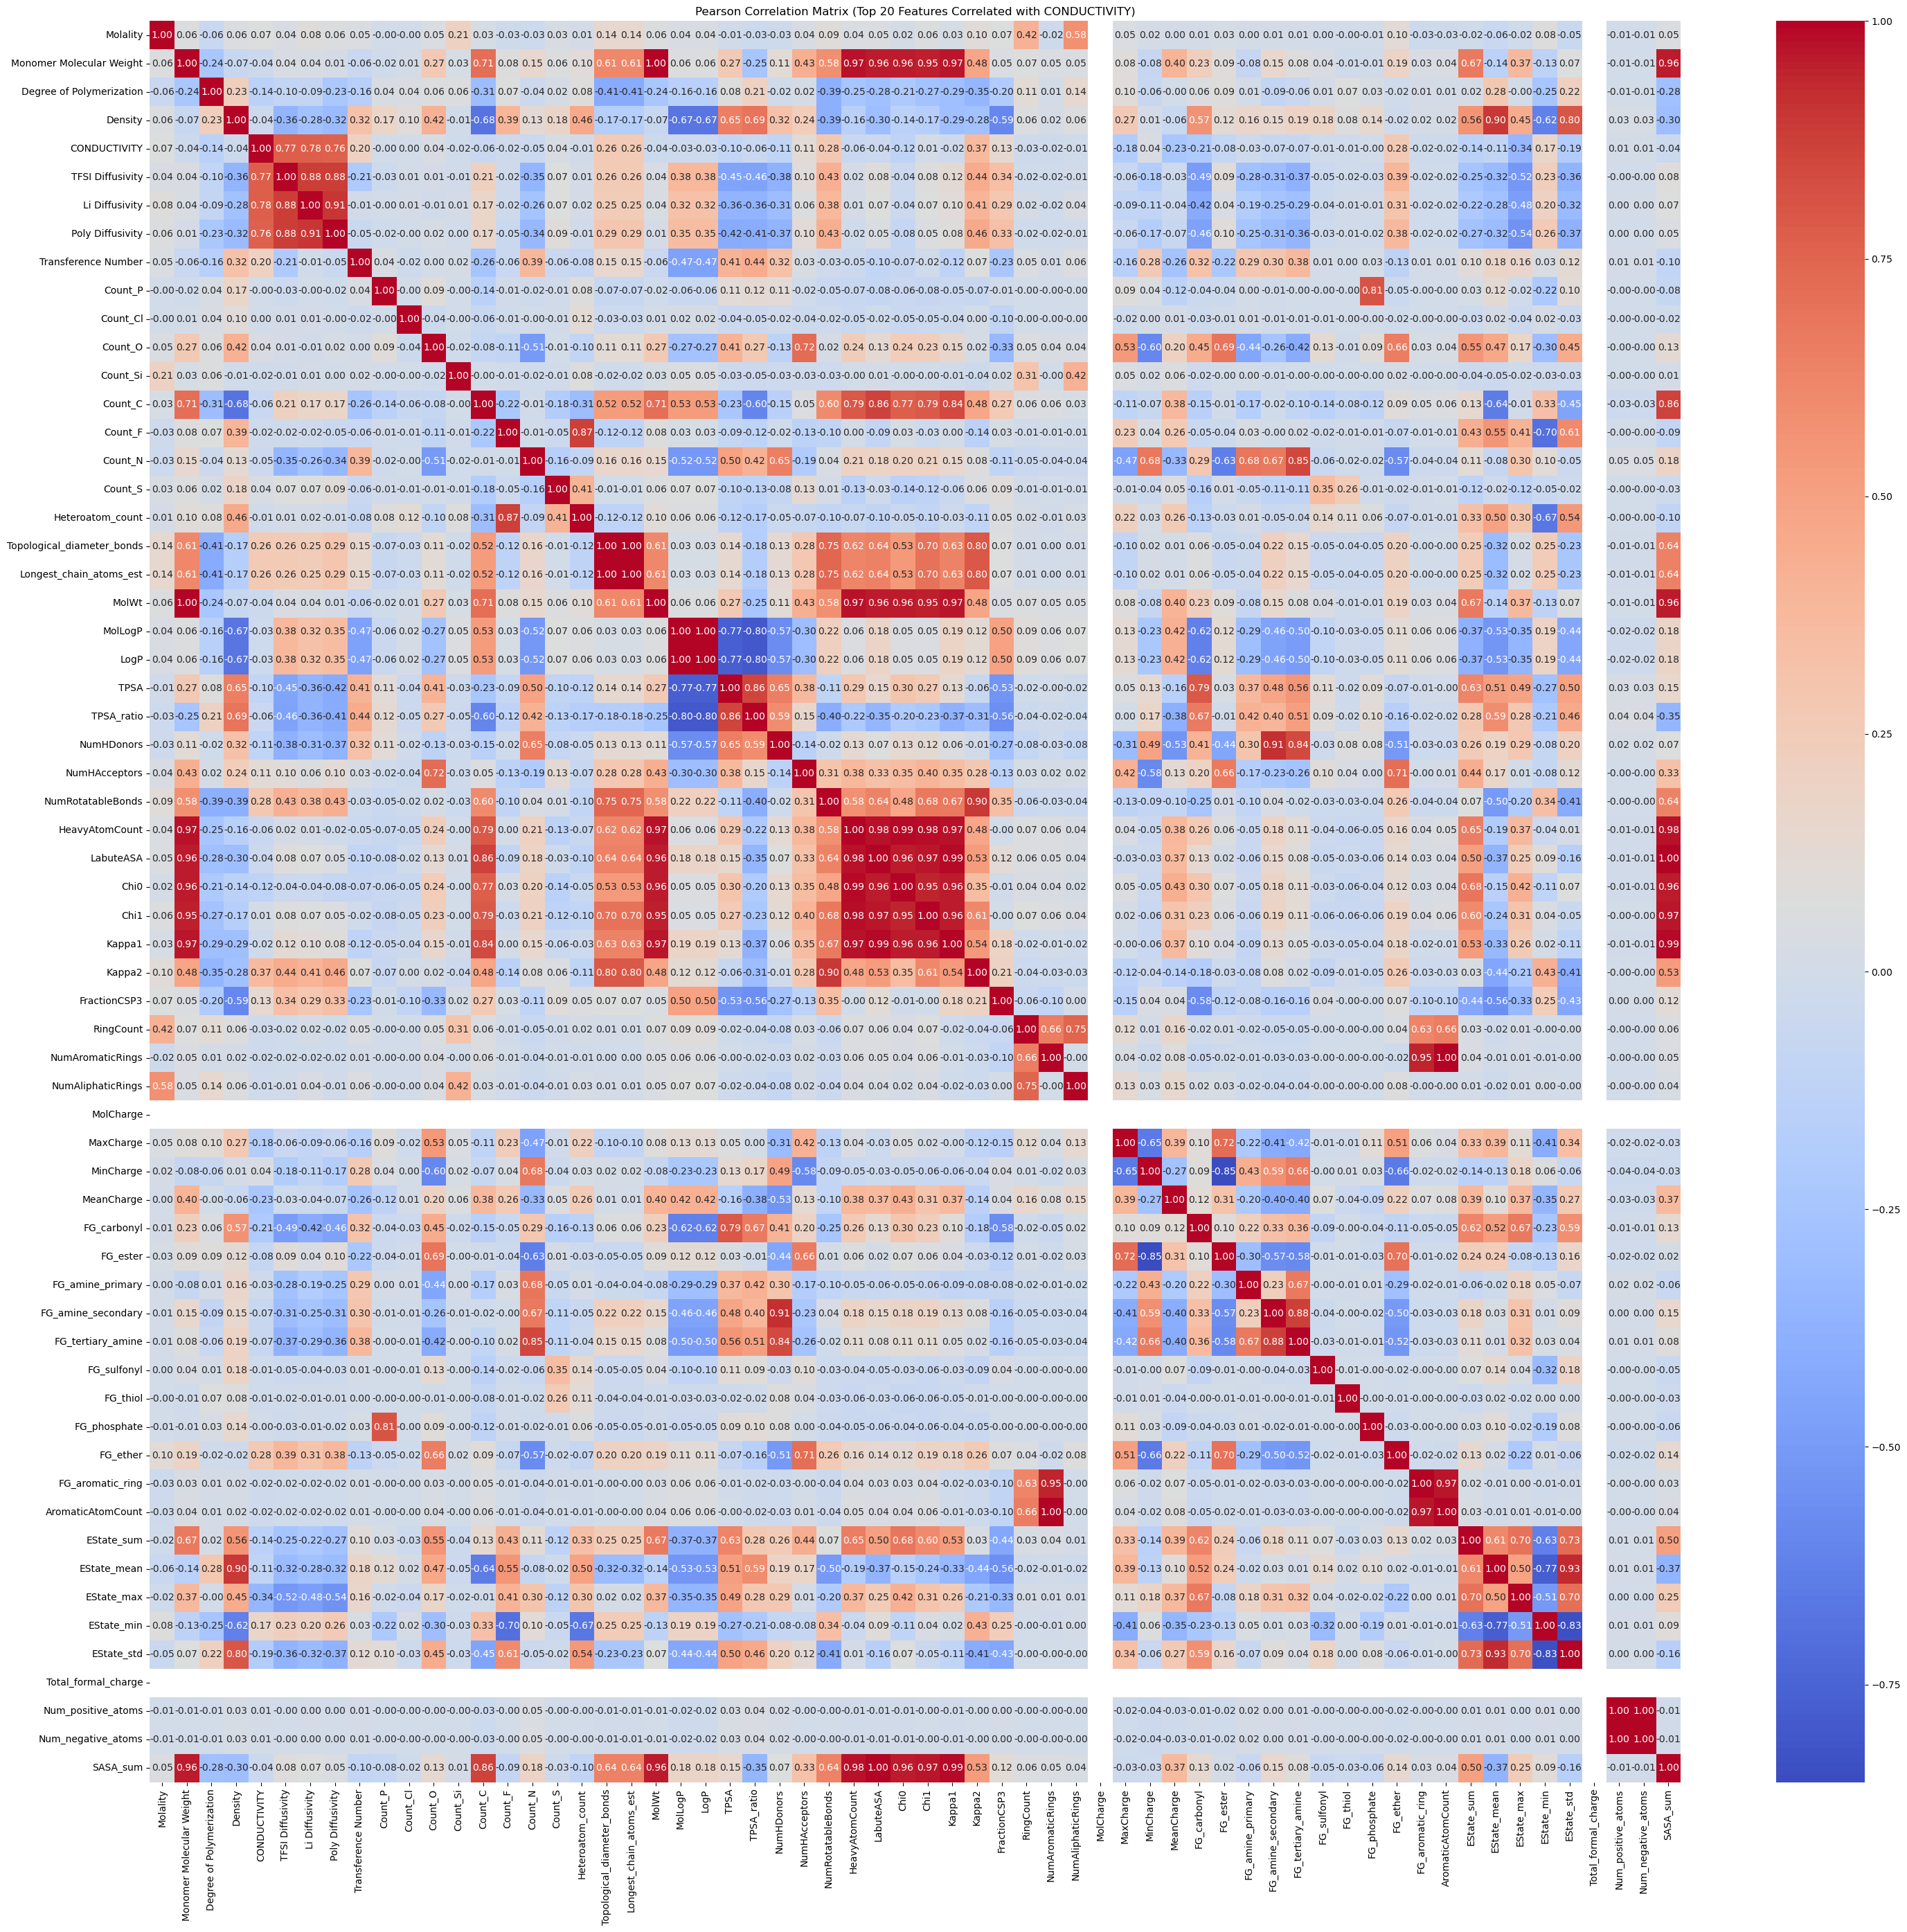

In [28]:
# --- Select numeric columns ---
numeric_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.tolist()

# --- Ensure target is included ---
target = "CONDUCTIVITY"
if target not in numeric_cols:
    numeric_cols.append(target)

# --- Compute correlation matrix ---
corr_matrix = df_final[numeric_cols].corr(method="pearson")

# --- Show correlations with target ---
corr_target = corr_matrix[target].sort_values(ascending=False)
top20_cols = corr_target.head(20).index.tolist()  # top 20 correlated features

print("\n=== Top 20 Correlations with ionic conductivity ===")
print(corr_target.head(20))

# --- Subset correlation matrix to top 20 ---
corr_top20 = corr_matrix.loc[top20_cols, top20_cols]

# --- Plot heatmap ---
plt.figure(figsize=(30, 28))
sns.heatmap(
    corr_matrix,
    # corr_top20,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
    # xticklabels=corr_top20.columns,
    # yticklabels=corr_top20.columns
)
plt.title("Pearson Correlation Matrix (Top 20 Features Correlated with CONDUCTIVITY)")
plt.tight_layout()
plt.show()


In [ ]:
# export to CSV
#df_final.to_csv("featurized_ionic_conductivity_dataset.csv", index=False)

In [ ]:
# now, we will use random forest to run the regression model on the featurized dataset

x = df_final.select_dtypes(include=['float64', 'int64']).drop(columns=['CONDUCTIVITY']).values
y = df_final['CONDUCTIVITY'].values

x

,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number,Count_P,Count_Cl,...,AromaticAtomCount,EState_sum,EState_mean,EState_max,EState_min,EState_std,Total_formal_charge,Num_positive_atoms,Num_negative_atoms,SASA_sum
0,1.4005,467.71,19.0,1.3494,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760,0,0,...,0,43.166667,3.083333,12.105997,-0.789588,4.210616,0,0,0,82.192090
1,1.4735,475.72,13.0,1.4561,1.317300e-08,1.105800e-08,8.636900e-09,0.317530,0,0,...,0,46.333333,3.088889,10.992087,-0.436366,4.063489,0,0,0,87.331572
2,1.4422,462.68,17.0,1.5336,1.397400e-08,1.952200e-08,9.183200e-09,0.529740,0,0,...,0,48.166667,3.440476,10.898291,-1.056250,4.502828,0,0,0,80.211002
3,1.4327,476.75,16.0,1.2767,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160,0,0,...,0,43.750000,2.916667,11.381498,-0.883694,3.946091,0,0,0,89.368098
4,1.4680,477.69,26.0,1.4896,1.349100e-08,6.582900e-09,8.672500e-09,0.080645,0,0,...,0,49.666667,3.311111,11.077874,-0.715411,4.407540,0,0,0,86.349599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1.3617,474.73,17.0,1.2898,2.621800e-08,1.083600e-08,1.632100e-08,-0.670610,0,0,...,0,45.250000,3.016667,10.963959,-1.305461,3.927134,0,0,0,88.678495
6266,1.4559,459.76,19.0,1.2026,2.438100e-08,2.447000e-08,2.782100e-08,0.345690,0,0,...,0,36.666667,2.619048,10.154311,-0.134622,3.162028,0,0,0,84.953290
6267,1.3738,471.77,19.0,1.2302,3.741000e-08,2.431500e-08,1.979900e-08,-0.096209,0,0,...,0,39.666667,2.644444,10.127737,-0.185857,3.142681,0,0,0,91.217032
6268,1.4559,459.76,19.0,1.2254,4.686200e-08,2.154000e-08,3.485500e-08,-0.511600,0,0,...,0,36.500000,2.607143,10.069162,-0.154259,3.099408,0,0,0,85.163262
